In [16]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)


# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal

from langchain_core.tools import tool
from typing_extensions import TypedDict
from typing import Annotated, Literal , List , Optional , Any
from pydantic import BaseModel, Field , field_validator, ValidationInfo , model_validator
from langgraph.graph.message import AnyMessage , add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
import sys
import os
from flask import Flask, request, jsonify
import requests
from datetime import datetime
from api.booking import BookingAPI
from api.geoCoding import GeoCodingAPI
from api.getKey import OAuthClient
from api.getQuotes import QuotesAPI
from api.is_Airport import IsAirport
from langgraph.checkpoint.memory import MemorySaver

from langgraph.prebuilt import create_react_agent
memory = MemorySaver()
jupiterAPI = os.getenv('JUPITER_API')
quoteAPI = str(jupiterAPI) + "/demand/v1/quotes"
bookingsAPI  = str(jupiterAPI) + '/demand/v1/bookings'
def getData_for_duckling(text, dims):
    url = 'http://localhost:8000/parse'
    data = {
        'locale': 'en_US',
        'text': text,
        'dims': dims,
        'tz': "Asia/Ho_Chi_Minh"
    }
    response = requests.post(url, data=data)
    if response.status_code == 200:
        json_response = response.json()
        # value = json_response[0]['value']['value']
        return json_response
    else:
        return f"Error: {response.status_code}"
pick_up_result = None
destination_result = None
booking_details = None
class Quote:
    def __init__(self, quote_id, expires_at, vehicle_type, price_value, price_currency, luggage, passengers, provider_name, provider_phone):
        self.quote_id = quote_id
        self.expires_at = expires_at
        self.vehicle_type = vehicle_type
        self.price_value = price_value
        self.price_currency = price_currency
        self.luggage = luggage
        self.passengers = passengers
        self.provider_name = provider_name
        self.provider_phone = provider_phone
    def to_dict(self):
        return {
            "quote_id": self.quote_id,
            "expires_at": self.expires_at,
            "vehicle_type": self.vehicle_type,
            "price_value": self.price_value,
            "price_currency": self.price_currency,
            "luggage": self.luggage,
            "passengers": self.passengers,
            "provider_name": self.provider_name,
            "provider_phone": self.provider_phone
        }
    def __repr__(self):
        return (f"Quote(quote_id={self.quote_id}, expires_at={self.expires_at}, vehicle_type={self.vehicle_type}, "
                f"price_value={self.price_value}, price_currency={self.price_currency}, luggage={self.luggage}, "
                f"passengers={self.passengers}, provider_name={self.provider_name}, provider_phone={self.provider_phone})")
class BookingCarDetails(BaseModel):
    """Details for the bookings car details"""
    name: str = Field(
        ...,
        description="The name of the person booking the ride. Do not autofill if not provided",
    )
    number_phone: str = Field(
        ...,
        description="The phone number of the user. Do not autofill if not provided",
    )
    pick_up_location: str = Field(
        ...,
        description="The location where the user will be picked up. This can be a full address or a specific location name. Do not autofill if not provided",
    )
    destination_location: str = Field(
        ...,
        description="The destination location for the ride. This can be a full address or a specific location name. Do not autofill if not provided"
    )
    pick_up_time: str = Field(
        ...,
        description="The time the user intends to be picked up. No format keeps the text related to time. Do not autofill if not provided"
    )

    @field_validator('pick_up_location')
    @classmethod
    def validate_pickup(cls, value:str, info: ValidationInfo):
        geoCodingAPI = GeoCodingAPI()
        if value == '':
            return ''
        else :
            geoCoding_pickup = geoCodingAPI.get_geocoding(value)
            if geoCoding_pickup["status"] == "OK" :

                return geoCoding_pickup['results'][0]['formatted_address']
            else:
                raise ValueError(f"Invalid pick-up location: {value}")
    @field_validator('destination_location')
    @classmethod
    def validate_destination(cls, value : str, info: ValidationInfo):
        geoCodingAPI = GeoCodingAPI()
        if value == '':
            return ''
        else :
            geoCoding_destination = geoCodingAPI.get_geocoding(value)
            if geoCoding_destination["status"] == "OK":
                if geoCoding_destination['results'][0]['formatted_address'] == info.data['pick_up_location']:
                    raise ValueError(f"Invalid destination location: {value}")
                else:

                    return geoCoding_destination['results'][0]['formatted_address']
            else:
            
                raise ValueError(f"Invalid destination location: {value}")

        

In [17]:
import random
from typing import Annotated, Literal

from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command, interrupt

@tool 
def check_Airport(pick_up_location: str) :
    """Call the function to check if pick_up_location is an airport"""
    API_Airport = IsAirport(base_url=jupiterAPI + '/v2/distance/airport')
    geoCodingAPI = GeoCodingAPI()
    geoCoding_pickup = geoCodingAPI.get_geocoding(pick_up_location)
    if geoCoding_pickup["status"] == "OK":
        pick_up_lat = geoCoding_pickup['results'][0]['geometry']['location']['lat']
        pick_up_lng = geoCoding_pickup['results'][0]['geometry']['location']['lng']  
        is_Airport = API_Airport.is_Airport(pick_up_lat, pick_up_lng)
    return is_Airport[0]
@tool(response_format="content_and_artifact")
def get_quotes(booking_details : BookingCarDetails):
    """Call function to fetches quotes for car bookings based on the provided booking details."""
    quotesAPI = QuotesAPI(os.getenv("JUPITER_API") + "/demand/v1/quotes")
    geoCodingAPI = GeoCodingAPI()
    # geoCoding_destination =
    geoCoding_pickup =  geoCodingAPI.get_geocoding(booking_details.pick_up_location)
    geoCoding_destination = geoCodingAPI.get_geocoding(booking_details.destination_location)
    # input_datetime = datetime.fromisoformat(pick_up_time)
    pickup_datetime = "2025-03-10T12:24:10Z"
    
    pickup_coords = { "latitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lng']),}
    destination_coords = { "latitude": float(geoCoding_destination['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_destination['results'][0]['geometry']['location']['lng']),}
    quotes_data = quotesAPI.get_quotes(pickup_datetime, pickup_coords, destination_coords)
    print(quotes_data)
    quotes = []
    for item in quotes_data:
        quote = Quote(
        quote_id=item['quoteId'],
        expires_at=item['expiresAt'],
        vehicle_type=item['vehicleType'],
        price_value=item['price']['value'],
        price_currency=item['price']['currency'] if 'currency' in item['price'] and item['price']['currency'] is not None else 'CAD',
        luggage=item['luggage'],
        passengers=item['passengers'],
        provider_name=item['provider']['name'],
        provider_phone=item['provider']['phone']
        )
        quotes.append(quote)
    response = []
    for quote in quotes:
        response.append({
            "title": f"{quote.vehicle_type} - {quote.price_value} {quote.price_currency}",
            "payload": f"{quote.quote_id}"
        })
    print(response)
    return {"context": "Please user chooses quote"}, {"quotes": response}
@tool
def accept_booking(quote_Id: str ,booking_details : BookingCarDetails ):
    """Call function to accept booking with quote_ID."""
    bookingAPI = BookingAPI(bookingsAPI)
    # quote_id = tracker.get_slot("quoteId")
    person_name = booking_details.name
    number_contact = booking_details.number_phone
    
    passenger_info = {
        "title": "Mr",
        "phone": number_contact,
        "firstName": person_name,
        "lastName": ""
    }
    response = bookingAPI.create_booking(
        quote_id=quote_Id,
        passenger_info=passenger_info
    )
    return response



def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

In [ ]:
from typing import Literal
from typing_extensions import TypedDict

# from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["booking_manager", "info_handler"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = model.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [33]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


info_handler = create_react_agent(
    model, tools=[check_Airport], prompt=(
        """You are a UserInfoHandler responsible for retrieving and updating user booking information. 
        If user express the intention to book a ride please guide the user through a booking process. 
        Start get booking details : name, number phone, pick up location, destination location, pick up time
        Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        Explain you're gathering info to help.
        Call "check_Airport" to check pick up location. If it is an airport, ask the user if they want to provide a flight code to facilitate the trip.
        Please ask user confirm booking information
        If user confirm infomation or you need booking confirmation or pricing, ask 'booking_manager' for help. 
        You MUST include a clear, human-readable response before transferring to another agent."""
    )
)


def info_handler_node(state: State) -> Command[Literal["supervisor"]]:
    result = info_handler.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="info_handler")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
booking_manager = create_react_agent(model, tools=[get_quotes,accept_booking],
                                         prompt=(
    """You are a BookingManager specializing in booking car. 
    Call "get_quotes" to get quotes for the booking details
    Call "accept_booking" to accept booking with quote_ID 
    If you need user booking details, ask 'info_handler' for help. 
    You MUST include a clear, human-readable response before transferring to another agent."""
))


def booking_manager_node(state: State) -> Command[Literal["supervisor"]]:
    result = booking_manager.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="booking_manager")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("info_handler", info_handler_node)
builder.add_node("booking_manager", booking_manager_node)
graph = builder.compile()

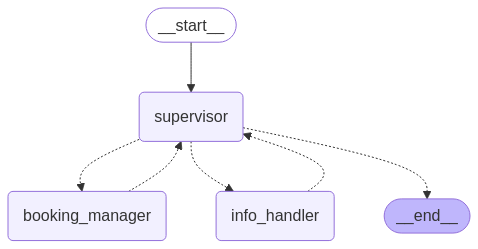

In [35]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
for s in graph.stream(
    {"messages": [("user", "i want to book a car from 271 Nguyen Van Linh Danang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and my phone number is 0123456789")]}, subgraphs=True
):
    print(s)
    print("----")

NameError: name 'llm' is not defined

In [ ]:

# from langgraph.graph import MessagesState, StateGraph, START
# from langgraph.prebuilt import create_react_agent, InjectedState
# from langgraph.types import Command, interrupt
# from langgraph.checkpoint.memory import MemorySaver
# from langchain_openai import ChatOpenAI

# model = ChatOpenAI(model="gpt-4o", temperature=0)

# # Define travel advisor tools and ReAct agent
# BookingManager_tools = [
#     get_quotes,accept_booking,
#     make_handoff_tool(agent_name="info_handler"),
# ]
# BookingManager = create_react_agent(
#     model,
#     BookingManager_tools,
#     prompt=(
#     """You are a BookingManager specializing in booking car. 
#     Call "get_quotes" to get quotes for the booking details
#     Call "accept_booking" to accept booking with quote_ID 
#     If you need user booking details, ask 'info_handler' for help. 
#     You MUST include a clear, human-readable response before transferring to another agent."""
# )
# )


# def call_booking_manager(
#     state: MessagesState,
# ) -> Command[Literal["info_handler", "human"]]:
#     # You can also add additional logic like changing the input to the agent / output from the agent, etc.
#     # NOTE: we're invoking the ReAct agent with the full history of messages in the state
#     response = BookingManager.invoke(state)
#     return Command(update=response, goto="human")


# # Define hotel advisor tools and ReAct agent
# InfoHandler_tools = [
#     check_Airport,
#     make_handoff_tool(agent_name="booking_manager"),
# ]
# InfoHandler = create_react_agent(
#     model,
#     InfoHandler_tools,
#     prompt=(
#         """You are a UserInfoHandler responsible for retrieving and updating user booking information. 
#         If user express the intention to book a ride please guide the user through a booking process. 
#         Start get booking details : name, number phone, pick up location, destination location, pick up time
#         Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
#         Explain you're gathering info to help.
#         Call "check_Airport" to check pick up location. If it is an airport, ask the user if they want to provide a flight code to facilitate the trip.
#         Please ask user confirm booking information
#         If user confirm infomation or you need booking confirmation or pricing, ask 'booking_manager' for help. 
#         You MUST include a clear, human-readable response before transferring to another agent."""
#     )

# )


# def call_info_handler(
#     state: MessagesState,
# ) -> Command[Literal["booking_manager", "human"]]:
#     response = InfoHandler.invoke(state)
#     return Command(update=response, goto="human")


# def human_node(
#     state: MessagesState, config
# ) -> Command[Literal["info_handler", "booking_manager", "human"]]:
#     """A node for collecting user input."""

#     user_input = interrupt(value="Ready for user input.")

#     # identify the last active agent
#     # (the last active node before returning to human)
#     langgraph_triggers = config["metadata"]["langgraph_triggers"]
#     if len(langgraph_triggers) != 1:
#         raise AssertionError("Expected exactly 1 trigger in human node")

#     active_agent = langgraph_triggers[0].split(":")[1]

#     return Command(
#         update={
#             "messages": [
#                 {
#                     "role": "human",
#                     "content": user_input,
#                 }
#             ]
#         },
#         goto=active_agent,
#     )


# builder = StateGraph(MessagesState)
# builder.add_node("booking_manager", call_booking_manager)
# builder.add_node("info_handler", call_info_handler)

# # This adds a node to collect human input, which will route
# # back to the active agent.
# builder.add_node("human", human_node)

# # We'll always start with a general travel advisor.
# builder.add_edge(START, "info_handler")


# checkpointer = MemorySaver()
# graph = builder.compile(checkpointer=checkpointer)

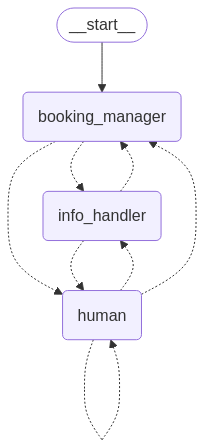

In [ ]:
# from IPython.display import display, Image

# display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# import uuid

# thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

# inputs = [
#     # 1st round of conversation,
#     {
#         "messages": [
#             {"role": "user", "content": "hi"}
#         ]
#     },
#     # Since we're using `interrupt`, we'll need to resume using the Command primitive.
#     # 2nd round of conversation,
#     Command(
#         resume="i want to book a car from 271 Nguyen Van Linh Danang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and my phone number is 0123456789"
#     ),
#     # 3rd round of conversation,
#     Command(
#         resume="ok"
#     ),
# ]

# for idx, user_input in enumerate(inputs):
#     print()
#     print(f"--- Conversation Turn {idx + 1} ---")
#     print()
#     print(f"User: {user_input}")
#     print()
#     for update in graph.stream(
#         user_input,
#         config=thread_config,
#         stream_mode="updates",
#     ):
#         print(f"Agent: {update}")
#         # for node_id, value in update.items():
#         #     if isinstance(value, dict) and value.get("messages", []):
#         #         last_message = value["messages"][-1]
#         #         if isinstance(last_message, dict) or last_message.type != "ai":
#         #             continue
#         #         print(f"{node_id}: {last_message.content}")


--- Conversation Turn 1 ---

User: {'messages': [{'role': 'user', 'content': 'hi'}]}

Agent: {'info_handler': {'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='d75adf6d-966a-43ba-9f5d-00a54167ac17'), AIMessage(content="I'm here to help you with booking a ride. Could you please provide your name?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 247, 'total_tokens': 266, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-b89025b8-4964-4a0f-8801-6e1d14972473-0', usage_metadata={'input_tokens': 247, 'output_tokens': 19, 'total_tokens': 266, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_d

In [ ]:
# import uuid

# thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

# inputs = [
#     # 1st round of conversation,
#     # {
#     #     "messages": [
#     #         {"role": "user", "content": "hi"}
#     #     ]
#     # },
#     # # Since we're using `interrupt`, we'll need to resume using the Command primitive.
#     # # 2nd round of conversation,
#     # Command(
#     #     resume="i want to book a car from 271 Nguyen Van Linh Danang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and my phone number is 0123456789"
#     # ),
#     # 3rd round of conversation,
#     Command(
#         resume="0b31d418-3208-4603-b53d-77764e971c35"
#     ),
# ]

# for idx, user_input in enumerate(inputs):
#     print()
#     print(f"--- Conversation Turn {idx + 1} ---")
#     print()
#     print(f"User: {user_input}")
#     print()
#     for update in graph.stream(
#         user_input,
#         config=thread_config,
#         stream_mode="updates",
#     ):
#         print(f"Agent: {update}")
#         # for node_id, value in update.items():
#         #     if isinstance(value, dict) and value.get("messages", []):
#         #         last_message = value["messages"][-1]
#         #         if isinstance(last_message, dict) or last_message.type != "ai":
#         #             continue
#         #         print(f"{node_id}: {last_message.content}")


--- Conversation Turn 1 ---

User: Command(resume='0b31d418-3208-4603-b53d-77764e971c35')



InvalidUpdateError: Must write to at least one of ['messages']

In [ ]:
# inputs = {"messages": []}  
# config = {"configurable": {"user":"huy","thread_id": "1"}}
# while True:
#     user_input = input("You: ")
#     if user_input == "q":
#         break
#     # print(state["booking_info"])
#     inputs["messages"].append(("user", user_input))
#     for update in graph.stream(
#         inputs,
#         config=config,
#         stream_mode="updates",
#     ):
#         for node_id, value in update.items():
#             if isinstance(value, dict) and value.get("messages", []):
#                 last_message = value["messages"][-1]
#                 if isinstance(last_message, dict) or last_message.type != "ai":
#                     continue
#                 print(f"{node_id}: {last_message.content}")
#     # for s in graph.stream(inputs,config=config, stream_mode="values"):
#     #     message = s["messages"][-1]
#     #     print(message.artifact if hasattr(message, "artifact") else None)
#     #     print(message)
#         # if isinstance(message, tuple):
#         #     print(f"Assistant: {message[1]}")
#         # else:
#         #     print(message.artifact if hasattr(message, "artifact") else None)
#         #     print(message)


info_handler: I'm here to help you with booking a ride. Could you please provide your name to get started?
info_handler: Thank you, Huy. Could you please provide your phone number so we can proceed with the booking?
